In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
path = "/content/gdrive/MyDrive/2018.csv"
df = pd.read_csv(path)

In [5]:
df.head()

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,...,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 27
0,2018-01-01,UA,2429,EWR,DEN,1517,1512.0,-5.0,15.0,1527.0,...,268.0,250.0,225.0,1605.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01,UA,2427,LAS,SFO,1115,1107.0,-8.0,11.0,1118.0,...,99.0,83.0,65.0,414.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01,UA,2426,SNA,DEN,1335,1330.0,-5.0,15.0,1345.0,...,134.0,126.0,106.0,846.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-01,UA,2425,RSW,ORD,1546,1552.0,6.0,19.0,1611.0,...,190.0,182.0,157.0,1120.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-01,UA,2424,ORD,ALB,630,650.0,20.0,13.0,703.0,...,112.0,106.0,83.0,723.0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7213446 entries, 0 to 7213445
Data columns (total 28 columns):
 #   Column               Dtype  
---  ------               -----  
 0   FL_DATE              object 
 1   OP_CARRIER           object 
 2   OP_CARRIER_FL_NUM    int64  
 3   ORIGIN               object 
 4   DEST                 object 
 5   CRS_DEP_TIME         int64  
 6   DEP_TIME             float64
 7   DEP_DELAY            float64
 8   TAXI_OUT             float64
 9   WHEELS_OFF           float64
 10  WHEELS_ON            float64
 11  TAXI_IN              float64
 12  CRS_ARR_TIME         int64  
 13  ARR_TIME             float64
 14  ARR_DELAY            float64
 15  CANCELLED            float64
 16  CANCELLATION_CODE    object 
 17  DIVERTED             float64
 18  CRS_ELAPSED_TIME     float64
 19  ACTUAL_ELAPSED_TIME  float64
 20  AIR_TIME             float64
 21  DISTANCE             float64
 22  CARRIER_DELAY        float64
 23  WEATHER_DELAY        float64
 24

In [6]:
df = df.drop('Unnamed: 27', axis=1)

In [7]:
#identify count of missing values in all columns

df.isnull().sum()

,0
FL_DATE,0
OP_CARRIER,0
OP_CARRIER_FL_NUM,0
ORIGIN,0
DEST,0
CRS_DEP_TIME,0
DEP_TIME,112317
DEP_DELAY,117234
TAXI_OUT,115830
WHEELS_OFF,115829


In [8]:
#The CRS_DEP_TIME column has time information in numerical format with the first 2 digits representing hours and last two digits representing minutes. COnvert the column values from float to time datatype

# Convert CRS_DEP_TIME to string and pad with leading zeros
df['CRS_DEP_TIME'] = df['CRS_DEP_TIME'].astype(str).str.zfill(4)

# Extract hours and minutes
df['CRS_DEP_HOUR'] = df['CRS_DEP_TIME'].str[:2]
df['CRS_DEP_MINUTE'] = df['CRS_DEP_TIME'].str[2:]

# Create a datetime object for departure time
df['CRS_DEP_TIME'] = pd.to_datetime(df['CRS_DEP_HOUR'] + ':' + df['CRS_DEP_MINUTE'], format='%H:%M').dt.time

# Drop temporary columns
df = df.drop(['CRS_DEP_HOUR', 'CRS_DEP_MINUTE'], axis=1)

In [9]:

for column in ['DEP_TIME', 'CRS_ARR_TIME', 'ARR_TIME']:
  # Convert to string and pad with leading zeros, handling missing values
  df[column] = df[column].astype(str).str.replace('.0', '', regex=False)  # Remove '.0'
  df[column] = df[column].apply(lambda x: x.zfill(4) if x.isdigit() else x) # Pad only if numeric
  #Alternatively, replacing the `nan` to an empty string before the conditional would result in the correct format as well
  df[column] = df[column].fillna('').apply(lambda x: x.zfill(4) if x.isdigit() else x)

  # Extract hours and minutes, handling missing or invalid values
  #Only perform operation if the string is 4 digits long and contains only digits
  df[column + '_HOUR'] = df[column].apply(lambda x: x[:2] if len(x) == 4 and x.isdigit() else None)
  df[column + '_MINUTE'] = df[column].apply(lambda x: x[2:] if len(x) == 4 and x.isdigit() else None)
  # Alternatively, skip these rows or apply custom logic
  df.loc[~df[column].str.isdigit(), column + '_HOUR'] = None
  df.loc[~df[column].str.isdigit(), column + '_MINUTE'] = None

  # Create a datetime object for the respective time
  df[column] = pd.to_datetime(df[column + '_HOUR'].astype(str) + ':' + df[column + '_MINUTE'].astype(str),
                             format='%H:%M', errors='coerce').dt.time #errors='coerce' to force NaT for invalid values


  # Drop temporary columns
  df = df.drop([column + '_HOUR', column + '_MINUTE'], axis=1)

In [10]:
for column in ['WHEELS_OFF', 'WHEELS_ON']:
  # Convert to string and pad with leading zeros, handling missing values
  df[column] = df[column].astype(str).str.replace('.0', '', regex=False)  # Remove '.0'
  df[column] = df[column].apply(lambda x: x.zfill(4) if x.isdigit() else x) # Pad only if numeric
  #Alternatively, replacing the `nan` to an empty string before the conditional would result in the correct format as well
  df[column] = df[column].fillna('').apply(lambda x: x.zfill(4) if x.isdigit() else x)

  # Extract hours and minutes, handling missing or invalid values
  #Only perform operation if the string is 4 digits long and contains only digits
  df[column + '_HOUR'] = df[column].apply(lambda x: x[:2] if len(x) == 4 and x.isdigit() else None)
  df[column + '_MINUTE'] = df[column].apply(lambda x: x[2:] if len(x) == 4 and x.isdigit() else None)
  # Alternatively, skip these rows or apply custom logic
  df.loc[~df[column].str.isdigit(), column + '_HOUR'] = None
  df.loc[~df[column].str.isdigit(), column + '_MINUTE'] = None

  # Create a datetime object for the respective time
  df[column] = pd.to_datetime(df[column + '_HOUR'].astype(str) + ':' + df[column + '_MINUTE'].astype(str),
                             format='%H:%M', errors='coerce').dt.time #errors='coerce' to force NaT for invalid values


  # Drop temporary columns
  df = df.drop([column + '_HOUR', column + '_MINUTE'], axis=1)

In [11]:
df.head()

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,...,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,2018-01-01,UA,2429,EWR,DEN,15:17:00,15:12:00,-5.0,15.0,15:27:00,...,0.0,268.0,250.0,225.0,1605.0,NaN,NaN,NaN,NaN,NaN
1,2018-01-01,UA,2427,LAS,SFO,11:15:00,11:07:00,-8.0,11.0,11:18:00,...,0.0,99.0,83.0,65.0,414.0,NaN,NaN,NaN,NaN,NaN
2,2018-01-01,UA,2426,SNA,DEN,13:35:00,13:30:00,-5.0,15.0,13:45:00,...,0.0,134.0,126.0,106.0,846.0,NaN,NaN,NaN,NaN,NaN
3,2018-01-01,UA,2425,RSW,ORD,15:46:00,15:52:00,6.0,19.0,16:11:00,...,0.0,190.0,182.0,157.0,1120.0,NaN,NaN,NaN,NaN,NaN
4,2018-01-01,UA,2424,ORD,ALB,06:30:00,06:50:00,20.0,13.0,07:03:00,...,0.0,112.0,106.0,83.0,723.0,NaN,NaN,NaN,NaN,NaN


Cancelled flights don't have actual departure time and other details. So imputing 0 for all cancelled flights in the missing fields

In [12]:
#Impute 0 for all missing values in following columns: CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY

columns_to_impute = ['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']
for column in columns_to_impute:
  df[column] = df[column].fillna(0)

In [14]:
df.isnull().sum()

,0
FL_DATE,0
OP_CARRIER,0
OP_CARRIER_FL_NUM,0
ORIGIN,0
DEST,0
CRS_DEP_TIME,0
DEP_TIME,112948
DEP_DELAY,117234
TAXI_OUT,115830
WHEELS_OFF,116753


Filtering out cancelled flights as our use case only covers delays

In [15]:
#Drop rows from df where Cancelled = 1

df = df[df['CANCELLED'] != 1]

In [16]:
df.isnull().sum()

,0
FL_DATE,0
OP_CARRIER,0
OP_CARRIER_FL_NUM,0
ORIGIN,0
DEST,0
CRS_DEP_TIME,0
DEP_TIME,628
DEP_DELAY,4743
TAXI_OUT,0
WHEELS_OFF,923


Dropping column cancelled and cancellation code, as we are not dealing with cancelled flights data

In [17]:
#Drop columns cancelled and cancellation code

# Drop 'CANCELLED' and 'CANCELLATION_CODE' columns
df = df.drop(['CANCELLED', 'CANCELLATION_CODE'], axis=1)

We are dropping all rows where the actual delay time is present, but not the actual arrival time is given. This seems like incomplete/missing data

In [18]:
#Subset for all rows where DEP_TIME is not null and store in df_dep

df_dep = df[df['DEP_TIME'].notnull()]

In [19]:
df.shape

(7096862, 25)

In [20]:
df_dep.shape

(7096234, 25)

In [21]:
#Drop all rows by checking for a condition: where DEP_TIME is not null but ARR_TIME is null

df_dep_arr = df_dep[df_dep['ARR_TIME'].notnull()]
df = df_dep_arr

In [22]:
df.shape

(7090109, 25)

In [23]:
df.isnull().sum()

,0
FL_DATE,0
OP_CARRIER,0
OP_CARRIER_FL_NUM,0
ORIGIN,0
DEST,0
CRS_DEP_TIME,0
DEP_TIME,0
DEP_DELAY,4737
TAXI_OUT,0
WHEELS_OFF,922


Dropping Diverted fkights as well, as these were not initially scheduled for the mentioned destinations, and does not contribute to our use case

In [24]:
#drop all rows where diverted = 1

df = df[df['DIVERTED'] != 1]

In [25]:
df = df.drop('DIVERTED', axis=1)

In [26]:
df.shape

(7074936, 24)

In [27]:
df.isnull().sum()

,0
FL_DATE,0
OP_CARRIER,0
OP_CARRIER_FL_NUM,0
ORIGIN,0
DEST,0
CRS_DEP_TIME,0
DEP_TIME,0
DEP_DELAY,4725
TAXI_OUT,0
WHEELS_OFF,922


In [29]:
#export df to downloadable csv file

from google.colab import files

df.to_csv('my_dataframe.csv', encoding = 'utf-8-sig')
files.download('my_dataframe.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Visuals performed before data cleaning for earlier week presentations**

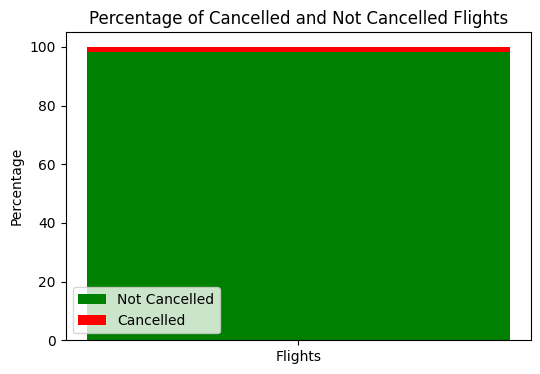

In [ ]:
#The 'Cancelled' column in df dataset has boolean values where 1 indicates that the flight was cancelled. Graph a stacked bar chart showing the percentage of cancelled flights to not cancelled flights

import matplotlib.pyplot as plt

# Calculate the percentage of cancelled flights
cancelled_percentage = df['CANCELLED'].mean() * 100
not_cancelled_percentage = 100 - cancelled_percentage

# Create a stacked bar chart
plt.figure(figsize=(6, 4))
plt.bar(['Flights'], [not_cancelled_percentage], color='green', label='Not Cancelled')
plt.bar(['Flights'], [cancelled_percentage], bottom=[not_cancelled_percentage], color='red', label='Cancelled')
plt.title('Percentage of Cancelled and Not Cancelled Flights')
plt.ylabel('Percentage')
plt.legend()
plt.show()

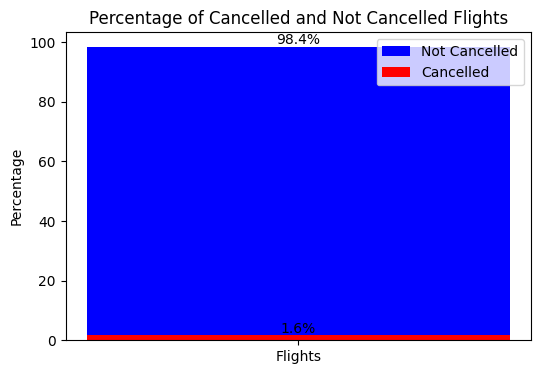

In [ ]:


# Calculate the percentage of cancelled flights
cancelled_percentage = df['CANCELLED'].mean() * 100
not_cancelled_percentage = 100 - cancelled_percentage

# Create a regular bar chart comparing cancelled and non-cancelled
plt.figure(figsize=(6, 4))

bar_width = 0.35
plt.bar(['Flights'], [not_cancelled_percentage], width=bar_width, color='blue', label='Not Cancelled')
plt.bar(['Flights'], [cancelled_percentage], width=bar_width, color='red', label='Cancelled')

# Annotate the bars with values
plt.text(0, not_cancelled_percentage, f'{not_cancelled_percentage:.1f}%', ha='center', va='bottom')
plt.text(0, cancelled_percentage, f'{cancelled_percentage:.1f}%', ha='center', va='bottom')

plt.title('Percentage of Cancelled and Not Cancelled Flights')
plt.ylabel('Percentage')
plt.legend()
plt.show()

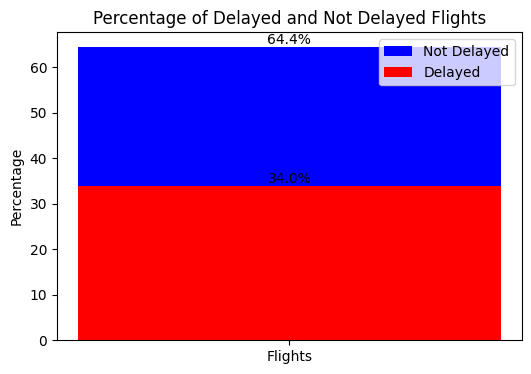

In [ ]:
# prompt: The 'DEP_DELAY' has negative values, indicating delay in flight. Show the % of flights that got delayed to the % not delayed using bar graph. Annotate the graph as well

# Calculate the percentage of delayed and not delayed flights
delayed_flights = df[df['DEP_DELAY'] > 0]['DEP_DELAY'].count()
not_delayed_flights = df[df['DEP_DELAY'] <= 0]['DEP_DELAY'].count()
total_flights = len(df)

delayed_percentage = (delayed_flights / total_flights) * 100
not_delayed_percentage = (not_delayed_flights / total_flights) * 100


# Create a regular bar chart comparing delayed and non-delayed
plt.figure(figsize=(6, 4))

bar_width = 0.35
plt.bar(['Flights'], [not_delayed_percentage], width=bar_width, color='blue', label='Not Delayed')
plt.bar(['Flights'], [delayed_percentage], width=bar_width, color='red', label='Delayed')

# Annotate the bars with values
plt.text(0, not_delayed_percentage, f'{not_delayed_percentage:.1f}%', ha='center', va='bottom')
plt.text(0, delayed_percentage, f'{delayed_percentage:.1f}%', ha='center', va='bottom')

plt.title('Percentage of Delayed and Not Delayed Flights')
plt.ylabel('Percentage')
plt.legend()
plt.show()

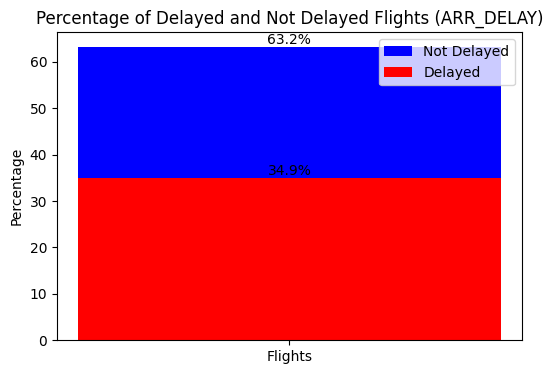

In [ ]:
# prompt: The 'ARR_DELAY' column has negative values, indicating delay in flight. Show the % of flights that got delayed to the % not delayed using bar graph. Annotate the graph as well

# Calculate the percentage of delayed and not delayed flights
delayed_flights = df[df['ARR_DELAY'] > 0]['ARR_DELAY'].count()
not_delayed_flights = df[df['ARR_DELAY'] <= 0]['ARR_DELAY'].count()
total_flights = len(df)

delayed_percentage = (delayed_flights / total_flights) * 100
not_delayed_percentage = (not_delayed_flights / total_flights) * 100


# Create a regular bar chart comparing delayed and non-delayed
plt.figure(figsize=(6, 4))

bar_width = 0.35
plt.bar(['Flights'], [not_delayed_percentage], width=bar_width, color='blue', label='Not Delayed')
plt.bar(['Flights'], [delayed_percentage], width=bar_width, color='red', label='Delayed')

# Annotate the bars with values
plt.text(0, not_delayed_percentage, f'{not_delayed_percentage:.1f}%', ha='center', va='bottom')
plt.text(0, delayed_percentage, f'{delayed_percentage:.1f}%', ha='center', va='bottom')

plt.title('Percentage of Delayed and Not Delayed Flights (ARR_DELAY)')
plt.ylabel('Percentage')
plt.legend()
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7213446 entries, 0 to 7213445
Data columns (total 28 columns):
 #   Column               Dtype  
---  ------               -----  
 0   FL_DATE              object 
 1   OP_CARRIER           object 
 2   OP_CARRIER_FL_NUM    int64  
 3   ORIGIN               object 
 4   DEST                 object 
 5   CRS_DEP_TIME         int64  
 6   DEP_TIME             float64
 7   DEP_DELAY            float64
 8   TAXI_OUT             float64
 9   WHEELS_OFF           float64
 10  WHEELS_ON            float64
 11  TAXI_IN              float64
 12  CRS_ARR_TIME         int64  
 13  ARR_TIME             float64
 14  ARR_DELAY            float64
 15  CANCELLED            float64
 16  CANCELLATION_CODE    object 
 17  DIVERTED             float64
 18  CRS_ELAPSED_TIME     float64
 19  ACTUAL_ELAPSED_TIME  float64
 20  AIR_TIME             float64
 21  DISTANCE             float64
 22  CARRIER_DELAY        float64
 23  WEATHER_DELAY        float64
 24

In [ ]:
# prompt: replace null values in ARR_Delay column with 0

df['ARR_DELAY'] = df['ARR_DELAY'].fillna(0)

In [ ]:
delayed_flights = df[df['ARR_DELAY'] > 0]
delayed_flights.head()

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,...,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
4,2018-01-01,UA,2424,ORD,ALB,630,650.0,20.0,13.0,703.0,...,0.0,112.0,106.0,83.0,723.0,NaN,NaN,NaN,NaN,NaN
11,2018-01-01,UA,2416,ORD,CLE,2059,2300.0,121.0,24.0,2324.0,...,0.0,72.0,80.0,48.0,316.0,121.0,0.0,8.0,0.0,0.0
14,2018-01-01,UA,2413,ORD,BTV,2114,2230.0,76.0,14.0,2244.0,...,0.0,121.0,118.0,99.0,763.0,0.0,11.0,0.0,0.0,62.0
15,2018-01-01,UA,2412,MCO,LAX,653,747.0,54.0,14.0,801.0,...,0.0,337.0,338.0,302.0,2218.0,54.0,0.0,1.0,0.0,0.0
16,2018-01-01,UA,2411,EWR,SMF,1810,1922.0,72.0,16.0,1938.0,...,0.0,386.0,339.0,319.0,2500.0,7.0,0.0,0.0,0.0,18.0


In [ ]:
delayed_flights.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2516050 entries, 4 to 7213444
Data columns (total 27 columns):
 #   Column               Dtype  
---  ------               -----  
 0   FL_DATE              object 
 1   OP_CARRIER           object 
 2   OP_CARRIER_FL_NUM    int64  
 3   ORIGIN               object 
 4   DEST                 object 
 5   CRS_DEP_TIME         int64  
 6   DEP_TIME             float64
 7   DEP_DELAY            float64
 8   TAXI_OUT             float64
 9   WHEELS_OFF           float64
 10  WHEELS_ON            float64
 11  TAXI_IN              float64
 12  CRS_ARR_TIME         int64  
 13  ARR_TIME             float64
 14  ARR_DELAY            float64
 15  CANCELLED            float64
 16  CANCELLATION_CODE    object 
 17  DIVERTED             float64
 18  CRS_ELAPSED_TIME     float64
 19  ACTUAL_ELAPSED_TIME  float64
 20  AIR_TIME             float64
 21  DISTANCE             float64
 22  CARRIER_DELAY        float64
 23  WEATHER_DELAY        float64
 24  NAS

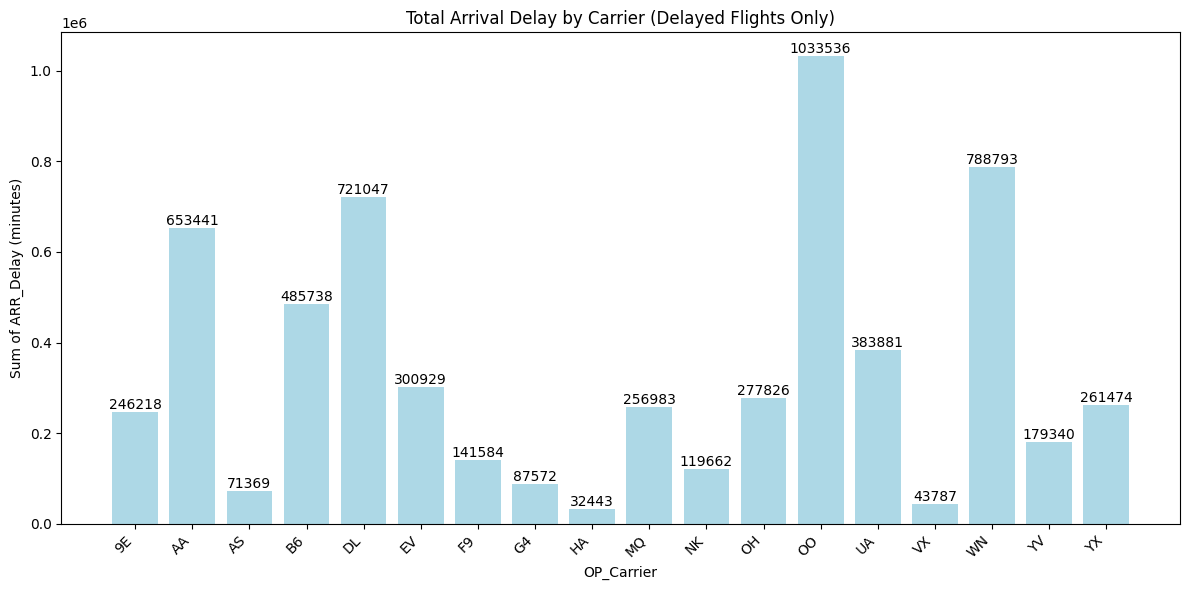

In [ ]:
# prompt: Show a bar graph with the sum of minutes of ARR_Delay in x axis, and OP_Carrier in Y axis. For the X axis, consider only delayed flights, that is ARR_delay > 0. Annotate the graph with the sum of minutes for each carrier. Keep the colour of the bars as light blue

import matplotlib.pyplot as plt

# Filter for delayed flights
delayed_flights = df[df['ARR_DELAY'] > 0]

# Group by carrier and sum arrival delay
carrier_delay_sums = delayed_flights.groupby('OP_CARRIER')['ARR_DELAY'].sum()

# Create a bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(carrier_delay_sums.index, carrier_delay_sums.values, color='lightblue')

# Add annotations
for bar in bars:
  yval = bar.get_height()
  plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.xlabel('OP_Carrier')
plt.ylabel('Sum of ARR_Delay (minutes)')
plt.title('Total Arrival Delay by Carrier (Delayed Flights Only)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

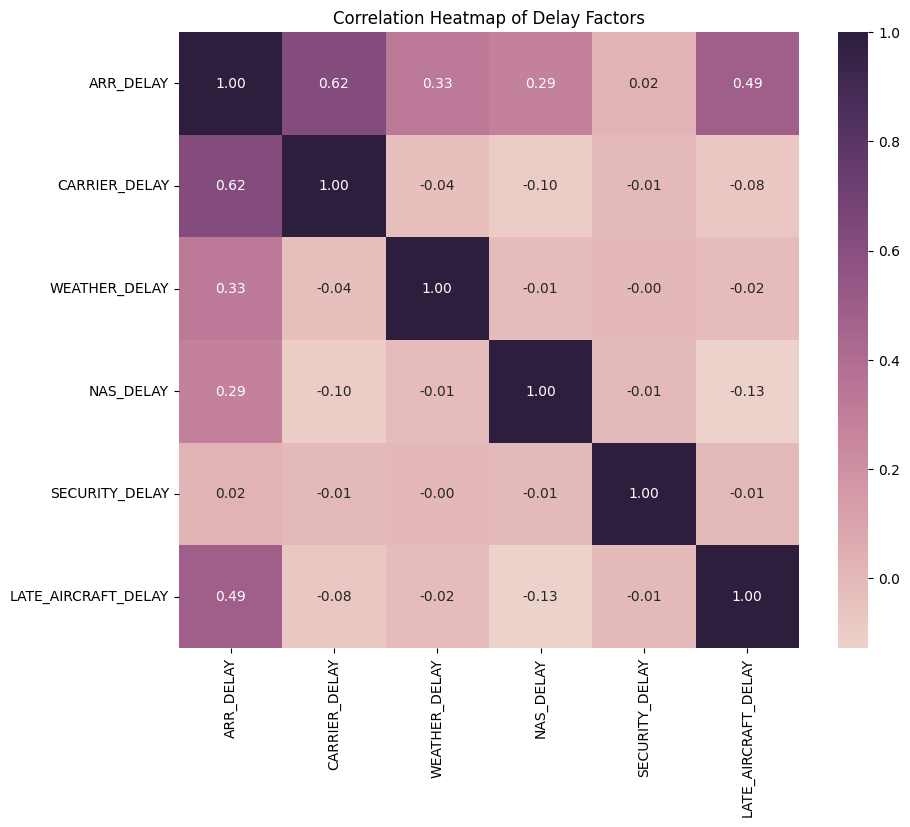

In [ ]:
# prompt: show a heatmap on delayed flights dataset, using columns ARR_Delay, Carrier_Delay, Weather_Delay, NAS_Delay, Security_Delay, Late_Aircraft_Delay

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df' and has the columns you mentioned

# Select only the relevant columns for the heatmap
heatmap_data = delayed_flights[['ARR_DELAY', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']]

# Create the heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(heatmap_data.corr(), annot=True, cmap=sns.cubehelix_palette(as_cmap=True), fmt=".2f")
plt.title('Correlation Heatmap of Delay Factors')
plt.show()

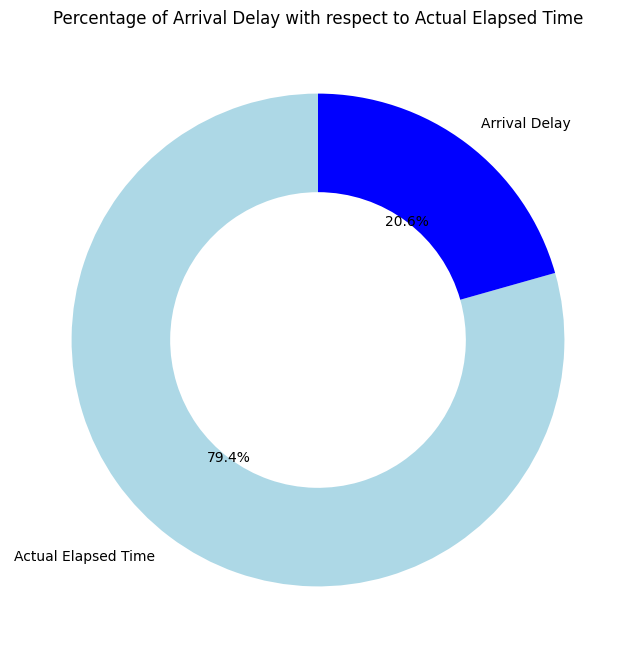

In [ ]:

# Calculate the total actual elapsed time and total arrival delay
total_actual_elapsed_time = delayed_flights['ACTUAL_ELAPSED_TIME'].sum()
total_arrival_delay = delayed_flights['ARR_DELAY'].sum()

# Calculate the percentage of total arrival delay with respect to total actual elapsed time
if total_actual_elapsed_time != 0:
    delay_percentage = (total_arrival_delay / total_actual_elapsed_time) * 100
else:
    delay_percentage = 0

# Create a doughnut chart
labels = ['Actual Elapsed Time', 'Arrival Delay']
sizes = [total_actual_elapsed_time, total_arrival_delay]
colors = ['lightblue', 'blue']

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.4))
plt.title('Percentage of Arrival Delay with respect to Actual Elapsed Time')

# Display the chart
plt.show()

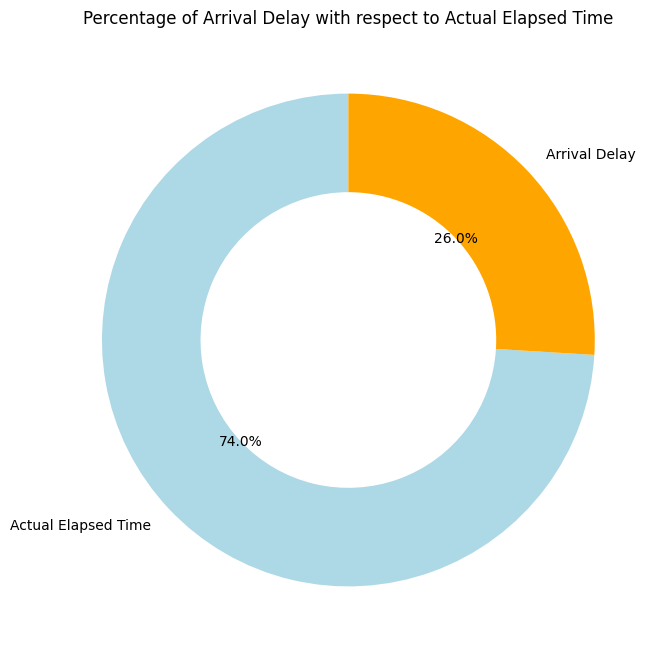

In [ ]:
# prompt: # Calculate the percentage of total arrival delay with respect to total actual elapsed time in delayed_flights dataframe. Create a doughnut chart. Annotate the percentage of the values in the chart, with the text completely outside of the pie

# Calculate the total actual elapsed time and total arrival delay
total_actual_elapsed_time = delayed_flights['ACTUAL_ELAPSED_TIME'].sum()
total_arrival_delay = delayed_flights['ARR_DELAY'].sum()

# Calculate the percentage of total arrival delay with respect to total actual elapsed time
if total_actual_elapsed_time != 0:
    delay_percentage = (total_arrival_delay / total_actual_elapsed_time) * 100
else:
    delay_percentage = 0

# Create a doughnut chart
labels = ['Actual Elapsed Time', 'Arrival Delay']
sizes = [total_actual_elapsed_time - total_arrival_delay, total_arrival_delay]
colors = ['lightblue', 'orange']

plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(sizes, labels=labels, colors=colors, startangle=90, wedgeprops=dict(width=0.4), autopct='%1.1f%%')

# Move the percentage text outside the pie
for autotext in autotexts:
    autotext.set_horizontalalignment('center')
    autotext.set_verticalalignment('center')


plt.title('Percentage of Arrival Delay with respect to Actual Elapsed Time')

# Display the chart
plt.show()